In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
# Load data from CSV file
data = pd.read_csv('../../../Dataset/FFIV_Stock.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

data

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,1/2/2019,FFIV,161.179993,161.179993,162.910004,158.190002,158.190002,758700
1,1/3/2019,FFIV,154.309998,154.309998,160.169998,153.910004,159.610001,1227800
2,1/4/2019,FFIV,159.789993,159.789993,160.130005,156.300003,156.699997,805100
3,1/7/2019,FFIV,163.820007,163.820007,165.470001,159.639999,159.949997,913300
4,1/8/2019,FFIV,164.820007,164.820007,166.369995,161.949997,165.169998,634200
...,...,...,...,...,...,...,...,...
1311,3/19/2024,FFIV,189.009995,189.009995,189.070007,185.759995,187.300003,342200
1312,3/20/2024,FFIV,189.529999,189.529999,190.190002,188.009995,189.119995,201600
1313,3/21/2024,FFIV,191.070007,191.070007,192.300003,189.229996,190.000000,278000
1314,3/22/2024,FFIV,190.570007,190.570007,191.279999,189.729996,191.279999,240000


In [3]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:2:1
df = data
df = df[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4852.159, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4850.565, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4850.928, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4851.021, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4848.565, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4852.365, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.495 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [5]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [6]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[160.1699982 160.1699982 160.1699982 160.1699982 160.1699982 160.1699982
 160.1699982 160.1699982 160.1699982 160.1699982 160.1699982 160.1699982
 160.1699982 160.1699982 160.1699982 160.1699982 160.1699982 160.1699982
 160.1699982 160.1699982 160.1699982 160.1699982 160.1699982 160.1699982
 160.1699982 160.1699982 160.1699982 160.1699982 160.1699982 160.1699982]


In [7]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)


Validation RMSE: 18.063618000151155
Testing RMSE: 14.84314135383924


Validation RMSE: 18.063618000151155
Testing RMSE: 14.84314135383924


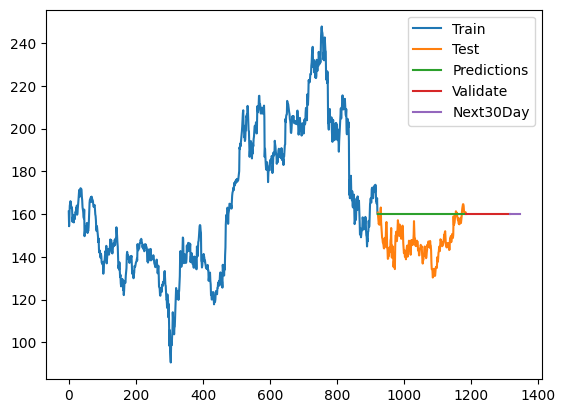

In [8]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [9]:
test_data.index

RangeIndex(start=921, stop=1184, step=1)

In [10]:
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MDA
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val) ** 2))
test_rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
valid_mape = calculate_mape(y_val, y_pred_val)
test_mape = calculate_mape(y_test, y_pred)
valid_mda = calculate_mda(y_val, y_pred_val)
test_mda = calculate_mda(y_test, y_pred)

# In kết quả
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 18.063618000151155
Testing RMSE: 14.84314135383924
Validation MAPE: 8.472925963747146
Testing MAPE: 9.140888810627011
Validation MDA: 0.0
Testing MDA: 0.38167938931297707
